# Image Classification Finetuning
    
    Step 1: Load the pre-trained model
    Step 2: Freeze the pre-trained layers
    Step 3: Modify the last layer
    Step 4: Load the custom dataset
    Step 5: Define the loss function and optimizer
    Step 6: Fine-tune the model on the custom dataset. The first training stage only unfreezes the last fc layer and the second stage unfreezes all layers.

reference: https://alirezasamar.com/blog/2023/03/fine-tuning-pre-trained-resnet-18-model-image-classification-pytorch/

## ResNet

In [1]:
import torch
from torchvision.models import resnet18, ResNet18_Weights
from torchcam.methods import CAM
from torchvision.io import read_image
from torchvision.transforms.functional import to_pil_image
from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask
import matplotlib.pyplot as plt

model = resnet18(weights=ResNet18_Weights.DEFAULT).eval() # pass weights = None to disable transfer learning

In [2]:
import os
DATA_DIR = '../../data/fruit/西梅/'
print(os.listdir(DATA_DIR))

['中度腐烂', '新鲜', '次新鲜', '轻度腐烂', '重度腐烂']


In [3]:
# Freeze all the pre-trained layers
for param in model.parameters():
    param.requires_grad = False

# Modify the last layer of the model
num_classes = len(os.listdir(DATA_DIR)) # replace with the number of classes in your dataset
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

In [4]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms

# Define the transformations to apply to the images
transform = transforms.Compose([
    # transforms.Resize(225),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the train and validation datasets
full_dataset = ImageFolder(DATA_DIR, transform=transform)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [0.7, 0.2, 0.1]) 

In [5]:
# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

from torch.utils.data import DataLoader

# Create data loaders for the train and validation datasets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [6]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    # Train the model for the specified number of epochs
    for epoch in range(num_epochs):
        # Set the model to train mode
        model.train()

        # Initialize the running loss and accuracy
        running_loss = 0.0
        running_corrects = 0

        # Iterate over the batches of the train loader
        for inputs, labels in train_loader:
            # Move the inputs and labels to the device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the optimizer gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Backward pass and optimizer step
            loss.backward()
            optimizer.step()

            # Update the running loss and accuracy
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # Calculate the train loss and accuracy
        train_loss = running_loss / len(train_dataset)
        train_acc = running_corrects.double() / len(train_dataset)

        # Set the model to evaluation mode
        model.eval()

        # Initialize the running loss and accuracy
        running_loss = 0.0
        running_corrects = 0

        # Iterate over the batches of the validation loader
        with torch.no_grad():
            for inputs, labels in val_loader:
                # Move the inputs and labels to the device
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Update the running loss and accuracy
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

        # Calculate the validation loss and accuracy
        val_loss = running_loss / len(val_dataset)
        val_acc = running_corrects.double() / len(val_dataset)

        # Print the epoch results
        print('Epoch [{}/{}], train loss: {:.4f}, train acc: {:.4f}, val loss: {:.4f}, val acc: {:.4f}'
              .format(epoch+1, num_epochs, train_loss, train_acc, val_loss, val_acc))

In [7]:
# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Fine-tune the last layer for a few epochs
optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.01, momentum=0.9)
train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

# Unfreeze all the layers and fine-tune the entire network for a few more epochs
for param in model.parameters():
    param.requires_grad = True
    
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

Epoch [1/10], train loss: 1.0788, train acc: 0.5697, val loss: 0.6613, val acc: 0.6848
Epoch [2/10], train loss: 0.5168, train acc: 0.7833, val loss: 0.2340, val acc: 0.9348
Epoch [3/10], train loss: 0.3092, train acc: 0.8669, val loss: 0.2339, val acc: 0.8913
Epoch [4/10], train loss: 0.2083, train acc: 0.9102, val loss: 0.2426, val acc: 0.9022
Epoch [5/10], train loss: 0.2618, train acc: 0.8762, val loss: 0.2155, val acc: 0.9130
Epoch [6/10], train loss: 0.2174, train acc: 0.9226, val loss: 0.2330, val acc: 0.8696
Epoch [7/10], train loss: 0.3775, train acc: 0.8483, val loss: 0.3484, val acc: 0.8913
Epoch [8/10], train loss: 0.3125, train acc: 0.8669, val loss: 0.3160, val acc: 0.8804
Epoch [9/10], train loss: 0.2382, train acc: 0.9009, val loss: 0.2400, val acc: 0.8913
Epoch [10/10], train loss: 0.1327, train acc: 0.9412, val loss: 0.2089, val acc: 0.9239
Epoch [1/10], train loss: 0.1084, train acc: 0.9567, val loss: 0.3995, val acc: 0.8587
Epoch [2/10], train loss: 0.0411, train ac

In [8]:
from datetime import datetime
ts = datetime.today().strftime('%Y%m%d%H%M')
MODEL_NAME = 'resnet18_'+ ts + '.pth'
torch.save(model, MODEL_NAME)

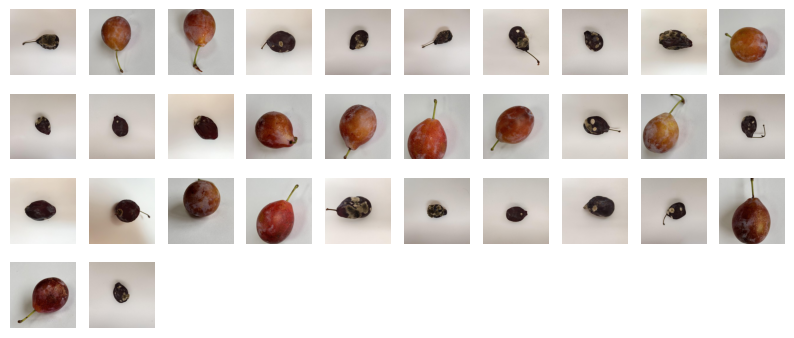

truth: 
 tensor([4, 1, 1, 3, 0, 0, 0, 4, 4, 1, 0, 3, 3, 1, 1, 1, 1, 0, 1, 3, 3, 0, 1, 1,
        0, 4, 3, 0, 3, 1, 1, 0], device='cuda:0')
prediction: 
 tensor([4, 1, 1, 3, 0, 3, 4, 0, 4, 1, 0, 3, 0, 1, 1, 1, 1, 3, 1, 3, 3, 3, 1, 1,
        4, 4, 3, 0, 3, 1, 1, 0], device='cuda:0')


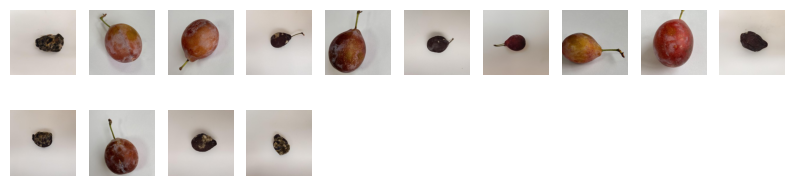

truth: 
 tensor([4, 1, 1, 0, 1, 3, 2, 1, 1, 3, 4, 1, 0, 4], device='cuda:0')
prediction: 
 tensor([4, 1, 1, 3, 1, 3, 2, 1, 1, 3, 4, 1, 0, 4], device='cuda:0')
Test set accuracy (%) = 82.60869598388672


In [9]:
import gc
torch.cuda.empty_cache()
gc.collect()

# Model class must be defined somewhere
model = torch.load(MODEL_NAME, weights_only=False).eval()

correct = 0
MEAN = torch.tensor([0.485, 0.456, 0.406])
STD = torch.tensor([0.229, 0.224, 0.225])

for inputs, labels in test_loader:
    plt.figure(figsize=(10,len(inputs)/10+1))
    for idx, img  in enumerate(inputs):
        plt.subplot(int(len(inputs)/10)+1, 10, idx+1)       
        x = img * STD[:, None, None] + MEAN[:, None, None]
        plt.imshow(x.numpy().transpose(1, 2, 0))
        plt.axis('off')
    plt.show()
    # Move the inputs and labels to the device
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    print('truth: \n', labels)
    print('prediction: \n', preds)
    correct += (preds == labels).float().sum()
    
accuracy = 100 * correct / len(test_dataset)
print('Test set accuracy (%) =', accuracy.item())

冬枣（['发霉', '干瘪', '新鲜', '次新鲜']）： Test set accuracy (%) = 100   
柿子（['中度腐烂', '新鲜', '次新鲜', '轻度腐烂', '重度腐烂']）： Test set accuracy (%) = 91.6   
西梅（['中度腐烂', '新鲜', '次新鲜', '轻度腐烂', '重度腐烂']）： Test set accuracy (%) = 82.6

TODO: 合并部分分类